In [ ]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [ ]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [ ]:
NUM_CLASSES = 5

# 入力長

In [ ]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [ ]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [ ]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [ ]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

32/32 [==============================] - 0s 1ms/step - loss: 1.2549 - accuracy: 0.5490 - val_loss: 1.1978 - val_accuracy: 0.6747
Epoch 9/1000
 1/32 [..............................] - ETA: 0s - loss: 1.2199 - accuracy: 0.5781
Epoch 9: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 2ms/step - loss: 1.2175 - accuracy: 0.5452 - val_loss: 1.1419 - val_accuracy: 0.6905
Epoch 10/1000
 1/32 [..............................] - ETA: 0s - loss: 1.1118 - accuracy: 0.6094
Epoch 10: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 2ms/step - loss: 1.1790 - accuracy: 0.5525 - val_loss: 1.0873 - val_accuracy: 0.7205
Epoch 11/1000
 1/32 [..............................] - ETA: 0s - loss: 1.2515 - accuracy: 0.5078
Epoch 11: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 2ms/step - loss: 1.

In [ ]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 27ms/step
[9.0000928e-20 9.2658836e-01 1.5225239e-02 5.7455033e-02 7.3142088e-04]
1


# 混同行列

42/42 [==============================] - 0s 441us/step


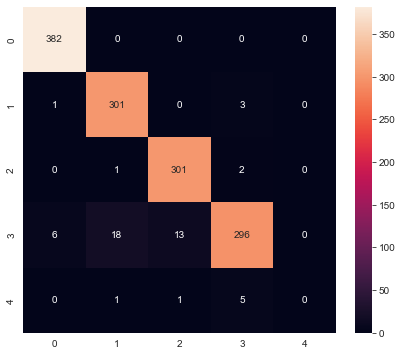

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       382
           1       0.94      0.99      0.96       305
           2       0.96      0.99      0.97       304
           3       0.97      0.89      0.93       333
           4       0.00      0.00      0.00         7

    accuracy                           0.96      1331
   macro avg       0.77      0.77      0.77      1331
weighted avg       0.96      0.96      0.96      1331



/Users/manideepguntuku/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manideepguntuku/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manideepguntuku/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [ ]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [ ]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [ ]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/hm/_fq8_bw50sn5kdfjqvjrygdw0000gn/T/tmppsf9rbu2/assets


INFO:tensorflow:Assets written to: /var/folders/hm/_fq8_bw50sn5kdfjqvjrygdw0000gn/T/tmppsf9rbu2/assets
2022-11-07 02:21:44.663325: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-07 02:21:44.663345: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-07 02:21:44.663434: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/hm/_fq8_bw50sn5kdfjqvjrygdw0000gn/T/tmppsf9rbu2
2022-11-07 02:21:44.664176: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-07 02:21:44.664182: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/hm/_fq8_bw50sn5kdfjqvjrygdw0000gn/T/tmppsf9rbu2
2022-11-07 02:21:44.666250: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-07 02:21:44.675756: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

TypeError: EndVector() missing 1 required positional argument: 'vectorNumElems'

# 推論テスト

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))